In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics
import math

In [3]:
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [4]:
tempdf = pd.DataFrame()
tempdf['Tmean'] = dataframe[['pH','Salinity','Ammonia']].mean()
tempdf['Tstd'] = dataframe[['pH','Salinity','Ammonia']].std()
for date in dataframe['Date of Image'].unique():
  df = dataframe.loc[dataframe['Date of Image'] == date]
  tempdf[f'{date}_mean'] = df[['pH','Salinity','Ammonia']].mean()
  tempdf[f'{date}_std'] = df[['pH','Salinity','Ammonia']].std()

In [5]:
tempdf

,Tmean,Tstd,2022-07-14_mean,2022-07-14_std,2022-09-12_mean,2022-09-12_std,2023-04-25_mean,2023-04-25_std,2023-05-30_mean,2023-05-30_std,2023-07-09_mean,2023-07-09_std
pH,8.205357,0.361522,8.600,0.106904,8.43750,0.170783,7.6250,0.150000,7.900000,0.264575,8.166667,0.276887
Salinity,33.678571,6.390638,37.875,1.807722,35.56250,3.898183,26.0000,3.366502,24.923077,1.754116,39.066667,2.051712
Ammonia,0.043750,0.032784,0.000,0.000000,0.02625,0.015438,0.0275,0.009574,0.074615,0.025038,0.063333,0.024398


In [6]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,612,1253,1154,919,1025,1059,1171,920,1188,165
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,484,1179,1065,794,854,918,1042,737,993,131
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,432,1114,969,708,779,727,825,641,897,170
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,524,1127,950,798,734,844,963,614,952,157
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,710,1236,1162,1108,1114,1217,1268,828,1254,169


In [7]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 22


In [8]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [9]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.042532
Salinity    0.142014
Ammonia     0.065567
dtype: float64

## WQI calculation

In [10]:
# def derivative(dataframe):
#     banddata = dataframe[bands]
#     for wave,band in (wavelengths,bands):



#     return None

def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.30,0.30,0.4]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 0
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf

def bandmath(bandMatrix,WQI):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/bandMatrix[a] + bandMatrix[b]
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex
  df['WQI_cal'] = WQI
  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  return  pca_data

def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 2.,  4.,  4.,  2.,  3.,  7., 10.,  6., 13.,  5.]),
 array([17.86666667, 22.70666667, 27.54666667, 32.38666667, 37.22666667,
        42.06666667, 46.90666667, 51.74666667, 56.58666667, 61.42666667,
        66.26666667]),
 <BarContainer object of 10 artists>)

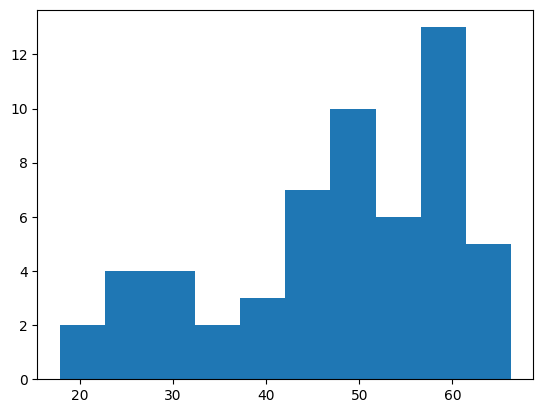

In [11]:
wqi,expdf= calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [12]:

## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 47.113095238095234
Standard Deviation WQI 12.664516051194644


## Model for the WQI to indiviual parameter

In [13]:
def CM(actual, predicted):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  plt.show()

def Presults(y_test, prediction):
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_

def LRegression(dataframe,index,pred, WQI_val,GT_val):

  WQI,GT = np.array(dataframe[index]).reshape(-1, 1),dataframe[pred]
  CM(GT,WQI)

  validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
  traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

  X_train = np.array((traindataframe[index])).reshape(-1, 1)
  y_train = traindataframe[pred]
  X_test = np.array((validationdataframe[index])).reshape(-1, 1)
  y_test = validationdataframe[pred]
  # X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)

  model = LinearRegression().fit(X_train, y_train)
  # model = SVR(kernel='rbf', C=2.0, epsilon=0.2).fit(X_train, y_train)
  if GT.name == 'Ammonia':
    # print('hi')
    model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
  prediction = model.predict(X_test)
  prediction_val = model.predict(WQI_val)
  for x,y in zip(y_test.values,prediction):
    print(x,'-',y)
  Presults(y_test, prediction)
  print(f"validation results on {GT_val.name}")
  Presults(GT_val,prediction_val)
  # for x,y in zip(GT_val,prediction_val):
  #   print(x,'-',y)
  # print(f"---------------------------------------")


#to predict the parameters from WQI



def WQIandParameters(dataframe,index,predictedWQI,gtforRE):
  print('-----For WQI with pH Regression relation-----')
  LRegression(dataframe,index,'pH',predictedWQI,gtforRE['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(dataframe,index,"Salinity",predictedWQI,gtforRE['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(dataframe,index,'Ammonia',predictedWQI,gtforRE['Ammonia'])
  return None



In [14]:
### adding wqi as a dataframe
dataframe["WQI"] = wqi

In [15]:
# sns.pairplot(dataframe)

## Model for Band to WQI index

In [16]:

def scaling(Banddata):
    scaler = StandardScaler()
    scaler.fit(Banddata)
    dataframe = scaler.transform(Banddata)
    return dataframe

def pca(dataframe):
  pca = PCA(n_components=3)
  pca.fit(dataframe)
  pca_df =  pca.transform(dataframe)
  return pca_df

# def weakmodel(xTrain, yTrain,xTest):
#       models = [
#         RandomForestRegressor(max_depth=3, random_state=0),
#         xgb.XGBRegressor(),
#         SVR(kernel='rbf', C=1.0, epsilon=1e-3)]

#       preds = []
#       for i, m in enumerate(models):
#           m.fit(xTrain, yTrain)
#           preds.append(m.predict(xTest))

#       weights = [0.33, 0.33,0.33]
#       preds = np.array(preds)
#       print
#       preds= np.sum(preds, axis = 0)/3
#       return preds

### model to predict WQI using bands as input
def predictWQI(dataframe,pred):
    # validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    # traindataframe.to_csv('WQIModelTrain.csv')
    # validationdataframe.to_csv('WQIModelTest.csv')

    # validationdataframe = dataframe[dataframe["Date of Image"]=="2022-09-12"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2022-09-12"]
    k =  10
    k_fold = KFold(n_splits = k,shuffle=True )


    gtforRE = (validationdataframe[parameters])

    xTrain = (scaling(traindataframe[bands]))
    yTrain = traindataframe[pred]
    xTest = (scaling(validationdataframe[bands]))
    yTest = validationdataframe[pred]

    model = SVR(kernel='rbf', C=2.0, epsilon=1e-4)
    # model = RandomForestRegressor(max_depth=3, random_state=0)
    # model = MLPRegressor(random_state=1, max_iter=100000)

    model.fit(xTrain, yTrain)

    # score = cross_val_score(model, dataframe[bands], dataframe[pred], cv = k_fold)
    # print(sum(score) / len(score))
    # print(score)
    # prediction =  weakmodel(xTrain,yTrain,xTest)
    prediction = model.predict(xTest)
    # prediction = preds
    # print(prediction,yTest)

    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction,gtforRE

In [17]:
(dataframe).corrwith(dataframe['WQI'])

<ipython-input-17-d8a89629dacb>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['WQI'])


pH             0.943750
Salinity       0.766900
Carbonate      0.843038
BiCarbonate   -0.064482
Alkalinity     0.216350
Hardness      -0.041913
Calcium       -0.768902
Magnesium      0.752689
Ammonia       -0.319667
Coincidence         NaN
B1            -0.677534
B10           -0.285340
B11           -0.536137
B12           -0.500540
B2            -0.679034
B3            -0.617105
B4            -0.652146
B5            -0.635764
B6            -0.626040
B7            -0.622534
B8            -0.640045
B8A           -0.591717
B9            -0.409001
WQI            1.000000
dtype: float64

(array([ 2.,  4.,  4.,  2.,  3.,  7., 10.,  6., 13.,  5.]),
 array([17.86666667, 22.70666667, 27.54666667, 32.38666667, 37.22666667,
        42.06666667, 46.90666667, 51.74666667, 56.58666667, 61.42666667,
        66.26666667]),
 <BarContainer object of 10 artists>)

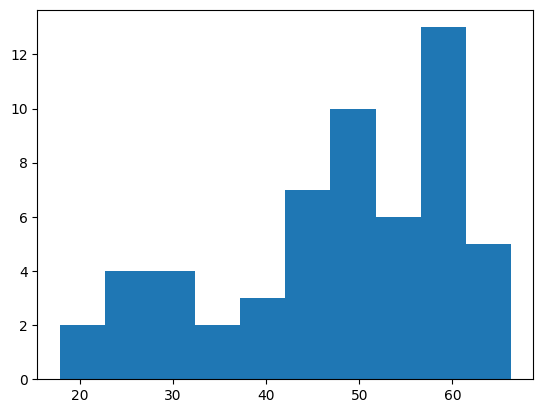

In [18]:

plt.hist(dataframe['WQI'])

MAE 8.820150007302658
MSE 120.73614664912763
RMSE 10.988000120546397
MAPE 0.2706692202516162
R2 Score 0.3571137339177852
-----For WQI with pH Regression relation-----


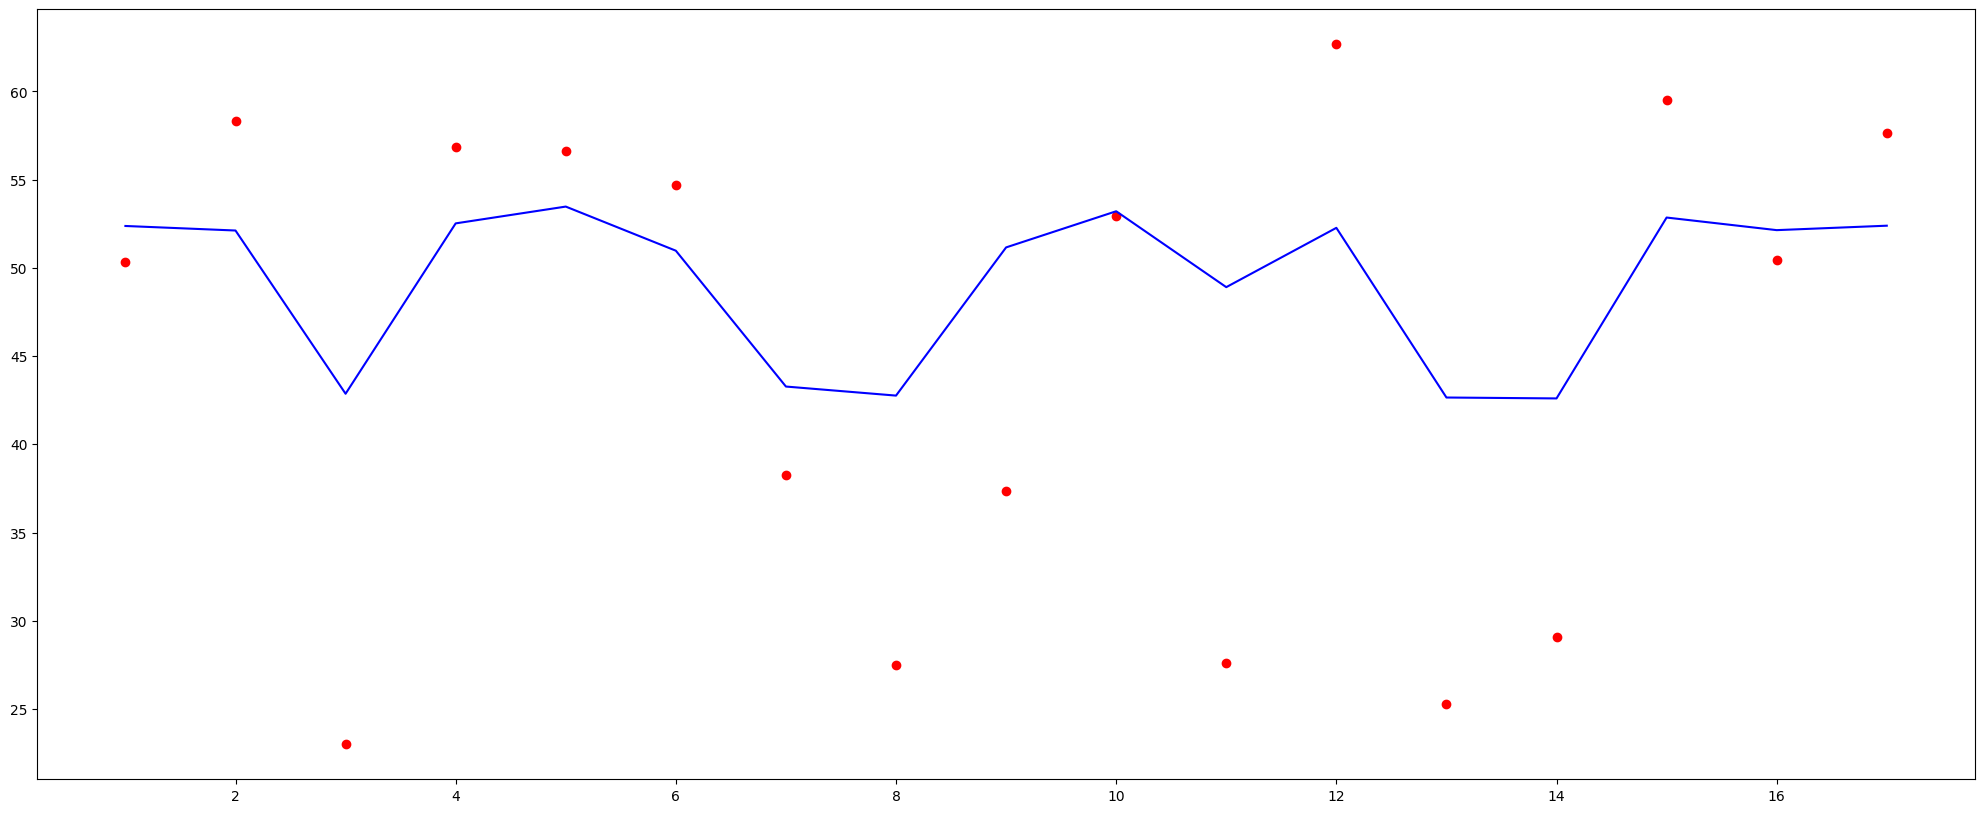

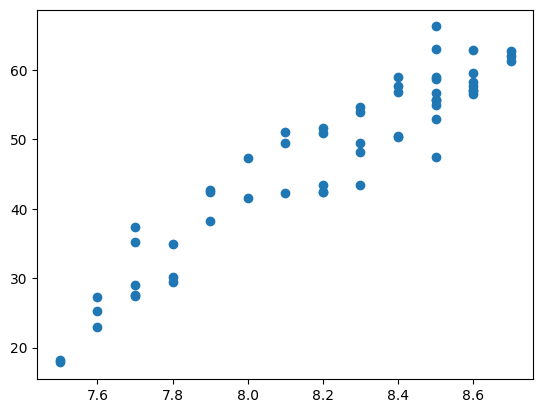

8.0 - 8.103185553830334
8.5 - 8.71160329104396
8.1 - 8.372546966900144
8.2 - 8.389499783107334
7.9 - 8.127672955018499
7.7 - 7.9845158403799985
8.5 - 8.802018310815644
8.2 - 8.366896028164412
8.4 - 8.596700870084112
8.0 - 8.265179130921268
8.1 - 8.3273394570143
8.3 - 8.474263864143289
8.3 - 8.455427401690855
8.6 - 8.70595235230823
7.7 - 7.924239160532209
MAE 0.20713606439697266
MSE 0.046279861101667125
RMSE 0.21512754612477483
MAPE 0.025466601562930787
R2 Score 0.35323175479036595
validation results on pH
MAE 0.27448255200153443
MSE 0.12229445239964276
RMSE 0.34970623729016154
MAPE 0.03476611464224071
R2 Score 0.28570944334080894
-----For WQI with Salinity  Regression relation-----


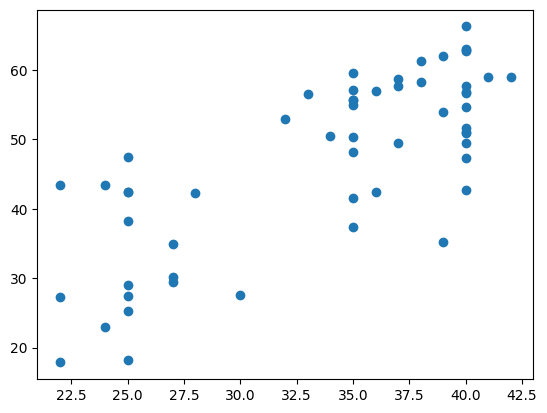

35 - 30.126495488277733
40 - 38.39459195302417
40 - 33.78698401601377
40 - 34.01736441286428
36 - 30.45926717261738
35 - 28.513832710324095
40 - 39.62328740289361
40 - 33.71019055039692
42 - 36.833124818815094
40 - 32.32790816929381
40 - 33.172636291079044
40 - 35.1692663971169
39 - 34.9132881783941
40 - 38.31779848740733
39 - 27.69470241041114
MAE 5.262617436071375
MSE 34.40285484397795
RMSE 5.865394687826042
MAPE 0.13554389001986392
R2 Score -7.756382737437827
validation results on Salinity
MAE 3.716878055915014
MSE 18.65498597418928
RMSE 4.319141809918873
MAPE 0.12338434687973905
R2 Score 0.41728372821652604
-----For WQI with Ammonia SVR relation-----


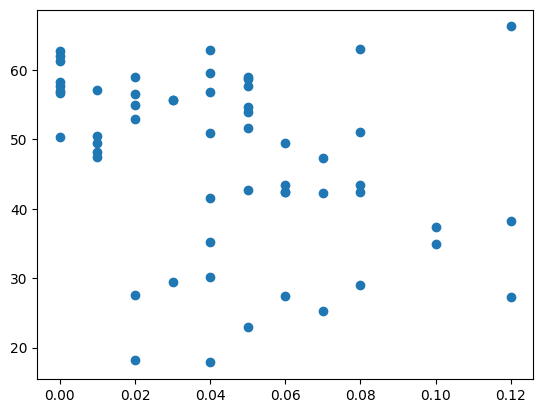

0.04 - 0.07150908486078762
0.08 - 0.008768506575553787
0.08 - 0.016073390685579603
0.05 - 0.016433711541194575
0.08 - 0.07150908486078762
0.1 - 0.07150908486078762
0.12 - 0.008768506575553787
0.04 - 0.016073390685579603
0.05 - 0.01767539512377986
0.07 - 0.016073390685579603
0.06 - 0.016073390685579603
0.05 - 0.018139488885195607
0.05 - 0.018139488885195607
0.04 - 0.008768506575553787
0.04 - 0.07057551343221621
MAE 0.04187195077780554
MSE 0.0023287846433494514
RMSE 0.04825748277054504
MAPE 0.6688831408087622
R2 Score -3.191812358029013
validation results on Ammonia
MAE 0.019858421633595042
MSE 0.0007926496526157135
RMSE 0.028154034393239515
MAPE 18111372919092.895
R2 Score 0.37615536599689214


In [19]:
predictedWQI,gtforRE = predictWQI(dataframe,"WQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE

WQIandParameters(dataframe,'WQI',predictedWQI.reshape(-1, 1),gtforRE)

Mean WQI 49.32236862498253
Standard Deviation WQI 4.439456787660925


(array([5., 0., 0., 0., 0., 1., 0., 2., 4., 5.]),
 array([42.59845788, 43.68555659, 44.7726553 , 45.85975401, 46.94685272,
        48.03395142, 49.12105013, 50.20814884, 51.29524755, 52.38234626,
        53.46944497]),
 <BarContainer object of 10 artists>)

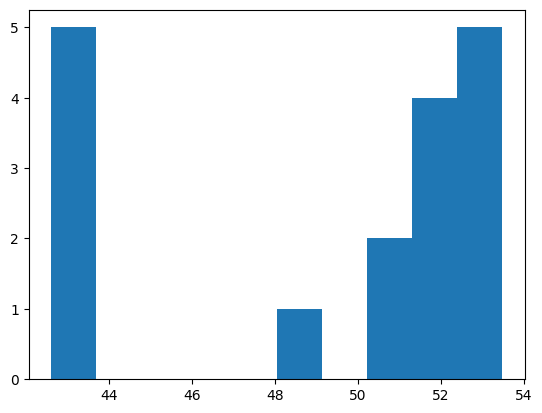

In [20]:
#
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(predictedWQI))
print("Standard Deviation WQI", statistics.stdev(predictedWQI))
plt.hist(predictedWQI)

# HQWI  Index


In [21]:
allWQI = harmonizedWQIcalculation(dataframe[parameters])
dataframe['HWQI'] = allWQI

(array([ 4.,  3.,  1., 20.,  5., 15.,  3.,  3.,  0.,  2.]),
 array([20.74961791, 21.84151438, 22.93341084, 24.02530731, 25.11720377,
        26.20910023, 27.3009967 , 28.39289316, 29.48478963, 30.57668609,
        31.66858255]),
 <BarContainer object of 10 artists>)

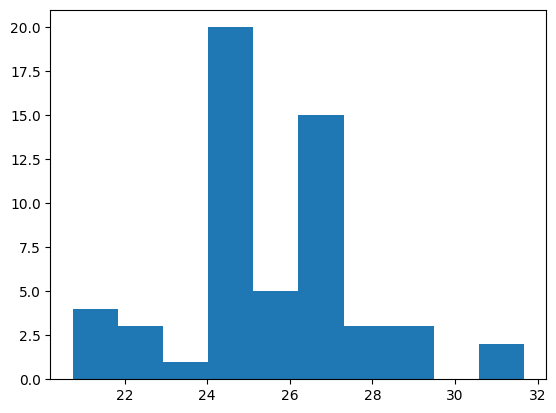

In [22]:
plt.hist(dataframe['HWQI'])

In [23]:
(dataframe).corrwith(dataframe['HWQI'])

<ipython-input-23-0036a586283d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['HWQI'])


pH             0.106968
Salinity       0.559821
Carbonate     -0.014115
BiCarbonate   -0.051408
Alkalinity    -0.010036
Hardness       0.433366
Calcium       -0.268119
Magnesium      0.457176
Ammonia        0.585113
Coincidence         NaN
B1            -0.494090
B10           -0.388352
B11           -0.323860
B12           -0.368513
B2            -0.551185
B3            -0.596716
B4            -0.556939
B5            -0.448563
B6            -0.405611
B7            -0.383047
B8            -0.440615
B8A           -0.398462
B9            -0.454930
WQI            0.401104
HWQI           1.000000
dtype: float64

MAE 1.1681816501197257
MSE 2.411876443992282
RMSE 1.5530217139474523
MAPE 0.04455369899179884
R2 Score 0.2809169394280393


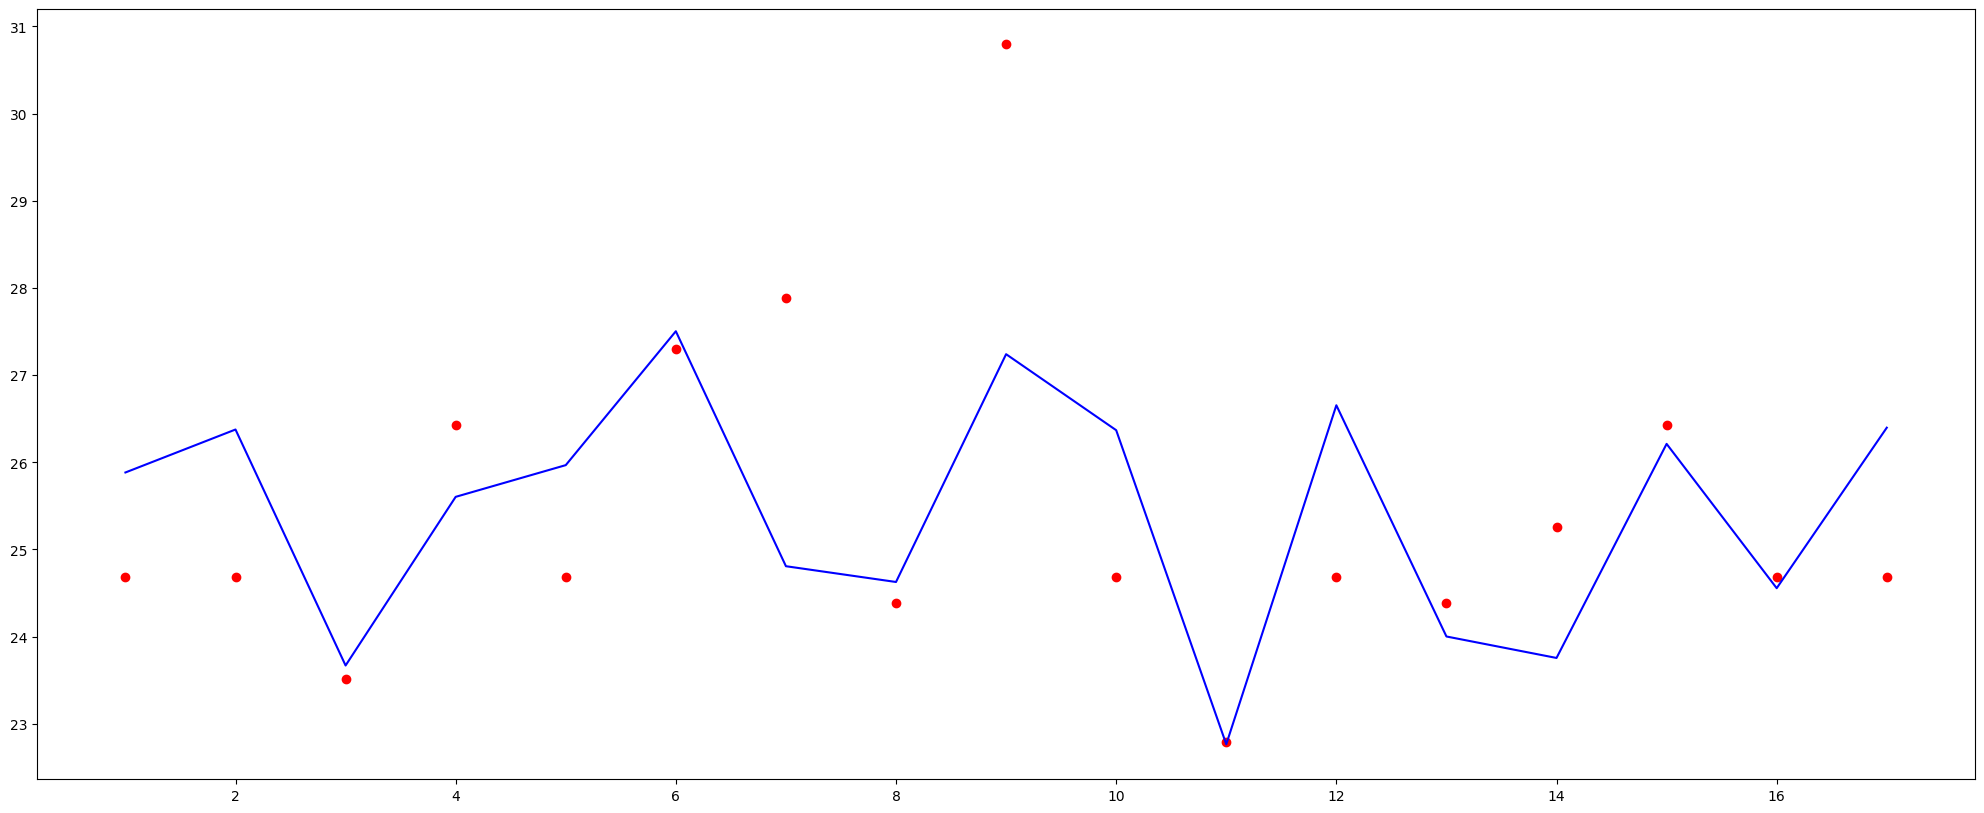

In [25]:
predictedWQI,gtforRE = predictWQI(dataframe,"HWQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)

# WQIandParameters(np.array(dataframe['HWQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

In [ ]:
## Not good code

In [ ]:


# #to train model to predict the WQI using band  indcies using ML
# def WQIandBands(df1,WQI):
#   print('-----For WQI prediction with Bands with SVR algo -----')
#   X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
#   X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
#   # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
#   model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
#   model.fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   return prediction


# def CM(actual, predicted):
#   fig = plt.figure()
#   plt.scatter(actual, predicted)
#   plt.show()

# def LRegression(WQI,GT):
#   X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
#   model = LinearRegression().fit(X_train, y_train)
#   # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
#   # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   for x,y in zip(y_test.values,prediction):
#     print(x,'-',y)

#   CM(WQI,GT)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   # return model.coef_,model.intercept_
# #to predict the parameters from WQI



# def WQIandParameters(WQI,GT):
#   print('-----For WQI with pH Regression relation-----')
#   LRegression(WQI,GT['pH'])
#   print('-----For WQI with Salinity  Regression relation-----')
#   LRegression(WQI,GT['Salinity'])
#   print('-----For WQI with Ammonia SVR relation-----')
#   LRegression(WQI,GT['Ammonia'])
#   return None



## WQI with only bands

In [ ]:
# WQI = WQIcalculation(df1 ,GT1)
# # len(WQI)
# WQIandBands(df1,WQI)
# WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

## WQI with  top  10 combination indices

In [ ]:
#   corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
# type(corrwithWQI)
# corrdict  = corrwithWQI.to_dict()
# sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
# for r in sortedkeys[:11]:
#     print(r, corrdict[r])

In [ ]:
# newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
# scaler = StandardScaler()
# scaler.fit(newtraindf)
# newscaledtraindf = scaler.transform(newtraindf)
# WQIandBands(newscaledtraindf,WQI)

In [ ]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands